In [20]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict palladium ("Close") returns with *lagged* Palladium returns. 

In [21]:
# Futures contract on the Palladium price:

palladium = pd.read_csv(
    Path("palladium.csv"), index_col="Date",parse_dates=True
)
palladium.tail()

,Close,Volume,Open,High,Low
Date,,,,,
2019-12-09,1856.6,2495,1850.2,1868.6,1844.4
2019-12-10,1871.3,N/A,1871.3,1871.3,1871.3
2019-12-11,1885.1,2894,1870.0,1892.0,1865.0
2019-12-12,1914.2,4115,1914.4,1920.1,1914.0
2019-12-13,1890.4,1,1890.4,1890.4,1890.4


In [22]:
# Trim the dataset to begin on December 15, 2014
palladium = palladium.loc["2014-12-15":, :]
palladium.head()



,Close,Volume,Open,High,Low
Date,,,,,
2014-12-15,802.55,232,797.15,801.10,796.60
2014-12-16,802.55,18,797.15,801.10,797.15
2014-12-17,779.25,4284,787.00,792.95,775.00
2014-12-18,792.15,3536,778.30,795.30,778.30
2014-12-19,805.10,2746,794.20,807.60,788.30


# Data Preparation

### Returns

In [23]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
palladium['Return'] = palladium.Close.pct_change() * 100
palladium = palladium.replace(-np.inf, np.nan).dropna()
palladium.tail()

,Close,Volume,Open,High,Low,Return
Date,,,,,,
2019-12-09,1856.6,2495,1850.2,1868.6,1844.4,0.672378
2019-12-10,1871.3,N/A,1871.3,1871.3,1871.3,0.791770
2019-12-11,1885.1,2894,1870.0,1892.0,1865.0,0.737455
2019-12-12,1914.2,4115,1914.4,1920.1,1914.0,1.543685
2019-12-13,1890.4,1,1890.4,1890.4,1890.4,-1.243339


### Lagged Returns 

In [24]:
# Create a lagged return using the shift function
palladium['Lagged_Return'] = palladium.Return.shift()
palladium = palladium.replace(-np.inf, np.nan).dropna()
palladium.tail()

,Close,Volume,Open,High,Low,Return,Lagged_Return
Date,,,,,,,
2019-12-09,1856.6,2495,1850.2,1868.6,1844.4,0.672378,-0.081270
2019-12-10,1871.3,N/A,1871.3,1871.3,1871.3,0.791770,0.672378
2019-12-11,1885.1,2894,1870.0,1892.0,1865.0,0.737455,0.791770
2019-12-12,1914.2,4115,1914.4,1920.1,1914.0,1.543685,0.737455
2019-12-13,1890.4,1,1890.4,1890.4,1890.4,-1.243339,1.543685


### Train Test Split

In [25]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = palladium[:'2018']
test = palladium['2018':]


In [26]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [27]:
X_train.head()

,Lagged_Return
Date,
2014-12-17,0.000000
2014-12-18,-2.903246
2014-12-19,1.655438
2014-12-22,1.634791
2014-12-23,1.260713


# Linear Regression Model

In [28]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [29]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [30]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
#Results.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021F407297B8>,
      dtype=object)

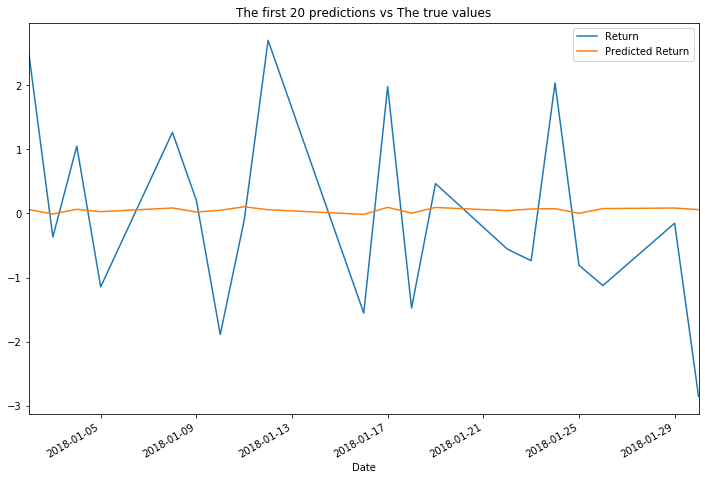

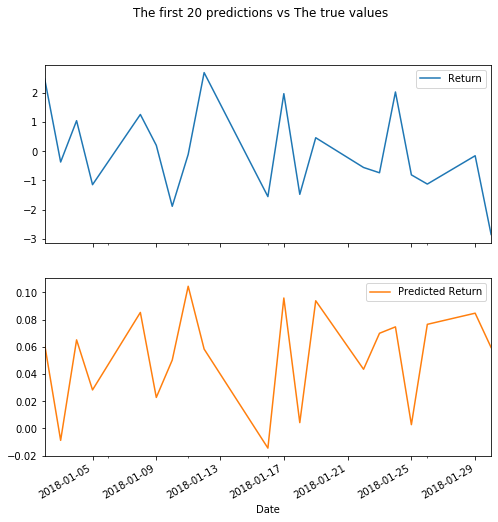

In [31]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='The first 20 predictions vs The true values', figsize=(12, 8))
Results[:20].plot(subplots=True, figsize=(8, 8), title='The first 20 predictions vs The true values')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [32]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 1.7207148874518423


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [33]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 1.7261150177063551


# Conclusions

YOUR CONCLUSIONS HERE!

### lower RMSE is the the sign of fitness of our model, that is why this model perform better with in-Sample data utilization! 